In [2]:
%matplotlib inline
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [8]:
from typing import Optional, Tuple, Dict
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisFromFunction
import numpy as np
import pandas as pd
import os
from polyphys.manage.typer import ParserT
from polyphys.manage.parser import SumRuleCyl, TransFociCyl, TransFociCub, Dump
from polyphys.manage.organizer import invalid_keyword, sort_filenames
from polyphys.analyze import clusters
from polyphys.probe.prober import stamps_report
import warnings

from MDAnalysis.analysis import polymer
from MDAnalysis.analysis import distances
from polyphys.manage.parser import HnsCub
from polyphys.manage import organizer

In [4]:
import MDAnalysis as mda
import MDAnalysis.analysis.msd as msd

In [ ]:
attr_labels = {
    "phi_c_bulk_round": "$\phi_c$",
    "time": "$\hat{{t}}$",
    "time_norm": "$\hat{{t}}/\hat{{t}}^{{max}}$",
    "lags": "$\hat{t}_{lags}$",
    "dmon_large": "${{a_M}}/{{a_m}}$",
    "dcrowd": "${{a_c}}/{{a_m}}$",
    "dcyl": "${{D}}/{{a_m}}$",
    "nmon_small": "$N_m$",
    "nmon_large": "$N_M$",
    'phi_c_bulk_norm': "${a\phi_c}/{a_c}$",
    'genomic_distance':  '$\Delta n$',
    'bin_center':'$r$',
    'bin_center-norm-dmon_large':'${{r}}/{{a_M}}$',
    'bin_center-norm':'${{r}}/{{r_{max}}}$',
    'bin_center-r':'$r$',
    'bin_center-norm-r':'${{2r}}/{{D}}$',
    'bin_center-recentered-norm-r':'${{(2r-a^{shift})}}/{{D}}$',
    'bin_center-dcrowd-r':'${{2r}}/{{a_c}}$',
    'bin_center-dcrowd-recentered-r':'${{(2r-a^{shift})}}/{{a_c}}$',
    'bin_center-z':'$z$',
    'bin_center-norm-z':'${{|z|}}/{{z_{max}}}$',
    'bin_center-dcrowd-z':'${{|z|}}/{{z_{max}}}$',
    'bin_center-dcrowd-recentered-z':'${{|z|}}/{{z_{max}}}$',
    'bin_center-theta':'$\theta$',
    'bin_center-dcrowd-theta':'${{\theta}}/{{\pi}}$',
    'bin_center-norm-theta':'${{\theta}}/{{\pi}}$',
    'nmon':'$N$',
    'nhns':'$N_{{hns}}$',
    'nmon_large':'$N_M$',
    'phi_c_rescaled':'$\\frac{{a\phi_c}}{{a_c}}$',
    'confinement_rate':'$\kappa=\\frac{{a_c}}{{D-a_c}}$',
    'confinement_rate_r':'$\kappa=\\frac{{D-a_c}}{{a_c}}$',
    'dep_energy_max':'$\mathcal{F}_{dep}=\phi_c^{(bulk)}[1+{{3a_m}}{{2a_c}}]$',
    'int_energy_max':'$\mathcal{F}_{int}=\\frac{{Na\phi_c^{(bulk)}}}{{a_c}}[3a_ma_c + \\frac{{3}}{{2}}]$',
    'species': 'Type'
}

### Probe explorations

In [12]:
# analyzing bug files.
group = 'nucleoid'
lineage = 'whole'
save_to = './'
#path = "/Users/amirhsi/OneDrive - University of Waterloo/PhD Research/Jupyter/N200epshm29kbmm10nh0ac2nc0l50dt0.005ndump2000adump5000ens1.ring"
path = "/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/N200epshm29kbmm20nh48ac2nc0l60dt0.005ndump2000adump5000ens1.ring"
path = "/Users/amirhsi_mini/research_data/N200epshm29kbmm10nh0ac2nc0l50dt0.005ndump2000adump5000ens1.ring"
nuc_pairs = glob(path + '/N*' + group + '*')
nuc_pairs = sort_filenames(
    nuc_pairs,
    fmts=['.' + group + '.data', '.' + group + '.lammpstrj']
)
nuc_pairs

[('/Users/amirhsi_mini/research_data/N200epshm29kbmm10nh0ac2nc0l50dt0.005ndump2000adump5000ens1.ring/N200epshm29kbmm10nh0ac2nc0l50dt0.005ndump2000adump5000ens1.ring.nucleoid.data',
  '/Users/amirhsi_mini/research_data/N200epshm29kbmm10nh0ac2nc0l50dt0.005ndump2000adump5000ens1.ring/N200epshm29kbmm10nh0ac2nc0l50dt0.005ndump2000adump5000ens1.ring.nucleoid.lammpstrj')]

In [9]:
%%time
trj = Dump(nuc_pairs[0][1])
trj.read_all()
trj.unwrap()
trj.write("N200epshm29kbmm10nh0ac2nc0l50dt0.005ndump2000adump5000ens1.unwrap.lammpstrj")

Assigned columns: id type x y z ix iy iz
list index out of range
100001 snapshots were read.
Unwrapping dump ...
100001 snapshots are written to a single dump file.
CPU times: user 2min 9s, sys: 1.71 s, total: 2min 11s
Wall time: 2min 14s


In [13]:
%%time
# 50 mins
for nucpair in nuc_pairs[:1]:
    topology = nucpair[0]
    trajectory = nucpair[1]
    lineage = 'whole'
    save_to = './'
    continuous = False
    if (lineage == 'segment') & (continuous is False):
        warnings.warn(
            "lineage is "
            f"'{lineage}' "
            "and 'continuous' is "
            f"'{continuous}. "
            "Please ensure the "
            f"'{trajectory}' is NOT part of a sequence of trajectories.",
            UserWarning
        )
    print("Setting the name of analyze file...")
    sim_info = HnsCub(
        trajectory,
        lineage,
        'cubic',
        'nucleoid',
        'ring'
    )
    sim_name = sim_info.lineage_name + "-" + sim_info.group
    print("\n" + sim_name + " is analyzing...\n")
    # LJ time difference between two consecutive frames:
    time_unit = sim_info.dmon * np.sqrt(
        sim_info.mmon * sim_info.eps_others)  # LJ time unit
    lj_nstep = sim_info.ndump  # Sampling steps via dump command in Lammps
    lj_dt = sim_info.dt
    sim_real_dt = lj_nstep * lj_dt * time_unit
    cell = mda.Universe(
        topology, trajectory, topology_format='DATA',
        format='LAMMPSDUMP', lammps_coordinate_convention='unscaled',
        #unwrap_images=True,
        atom_style="id resid type x y z", dt=sim_real_dt
        )
    #cell = mda.Universe(
    #    trajectory,
    #    format='LAMMPSDUMP', #lammps_coordinate_convention='unscaled',
    #    unwrap_images=True,
     #   atom_style="id resid type x y z", dt=sim_real_dt
    #    )
    #cell = mda.Universe(
    #    topology, topology_format='DATA',
    #    unwrap_images=True,
    #    )
    # slicing trajectory based the continuous condition
    #if continuous:
    #    sliced_trj = cell.trajectory[0: -1]
    #    n_frames = cell.trajectory.n_frames - 1
    #else:
    #    sliced_trj = cell.trajectory
    #    n_frames = cell.trajectory.n_frames
    # selecting atom groups
    bug = cell.select_atoms('resid 1')  # the bug
    hns_pole = cell.select_atoms('type 2')  # the hns holes
    hns_core = cell.select_atoms('type 3')  # the hns cores
    #ljcut_coeff = 1.122462
    #m_hcore_cutoff = 0.5*(sim_info.dmon + sim_info.dhns) # * ljcut_coeff
    #m_hpole_cutoff = 0.5*(sim_info.dmon + 0.178) # * ljcut_coeff
    #contact_m_hcore = np.zeros((sim_info.nmon, sim_info.nhns), dtype=np.float64)
    #contact_m_hpole = np.zeros((sim_info.nmon, 2*sim_info.nhns), dtype=np.float64)
    #contact_m_m_hcore = np.zeros((sim_info.nmon,sim_info.nmon), dtype=np.int64)
    #contact_m_m_hpole = np.zeros((sim_info.nmon,sim_info.nmon), dtype=np.int64)
    #for _ in sliced_trj:
        # bug:
        #dummy = distances.distance_array(bug, hns_core, box=cell.dimensions)
        #dummy = np.asarray(dummy <= m_hcore_cutoff, dtype=int)
        #contact_m_hcore += dummy
        #contact_dummy = np.matmul(dummy, dummy.T)
        #contact_m_m_hcore += contact_dummy
        #dummy = distances.distance_array(bug, hns_pole, box=cell.dimensions)
        #dummy = np.asarray(dummy <= m_hpole_cutoff, dtype=int)
        #contact_m_hpole += dummy
        #contact_dummy = np.matmul(dummy, dummy.T)
        #contact_m_m_hpole += contact_dummy
        #dummy = distances.distance_array(bug, hns_core, box=cell.dimensions)
        #dummy = np.asarray(dummy <= hns_core_mon_cutoff, dtype=int)
        #dist_array_core_contact += dummy
        #dummy = distances.distance_array(bug, hns_pole, box=cell.dimensions)
        #dummy = np.asarray(dummy <= hns_pole_mon_cutoff, dtype=int)
        #dist_array_pole_contact += dummy
        #dummy = distances.distance_array(bug, bug, box=cell.dimensions)
        #dummy = np.asarray(dummy <= mon_mon_cutoff, dtype=int)
        #dist_array_mon_contact += dummy

    #contact_m_hcore = contact_m_hcore / n_frames
    #np.save(
    #    save_to + sim_name + \
    #        f"-distCoreMonMean-cutoff{round(m_hcore_cutoff,3)}.npy",
    #    contact_m_hcore
    #)
    #contact_m_hpole = contact_m_hpole / n_frames
    #np.save(
    #    save_to + sim_name + \
    #        f"-distPoleMonMean-cutoff{round(m_hpole_cutoff,3)}.npy",
    #    contact_m_hpole
    #)
    #contact_m_m_hcore = contact_m_m_hcore / n_frames
    #np.save(
    #    save_to + sim_name + \
    #        f"-ContactMonMon-Core-cutoff{round(m_hcore_cutoff,3)}.npy",
    #    contact_m_m_hcore
    #)
    #contact_m_m_hpole = contact_m_m_hpole / n_frames
    #np.save(
    #    save_to + sim_name + \
    #        f"-ContactMonMon-Pole-cutoff{round(m_hpole_cutoff,3)}.npy",
    #    contact_m_m_hpole
    #)


Setting the name of analyze file...

N200epshm29kbmm10nh0ac2nc0l50dt0.005ndump2000adump5000ens1.ring-nucleoid is analyzing...

CPU times: user 4.52 s, sys: 308 ms, total: 4.82 s
Wall time: 5.31 s


In [15]:
for _ in cell.trajectory[-1:]:
    print(bug.positions[-50:])

[[ 33.1824   114.0314    -7.61906 ]
 [ 33.6557   114.1507    -8.43877 ]
 [ 33.896    114.0214    -9.29856 ]
 [ 34.2806   113.8771   -10.1682  ]
 [ 34.6022   113.7396   -11.0771  ]
 [ 34.7641   113.0717   -11.8494  ]
 [ 34.8545   112.7267   -12.7844  ]
 [ 34.7733   112.5183   -13.6577  ]
 [ 34.4661   111.8284   -14.2153  ]
 [ 33.8578   111.1153   -14.5481  ]
 [ 33.4257   110.2515   -14.7913  ]
 [ 32.9367   109.47159  -15.0048  ]
 [ 32.7341   108.52356  -14.8028  ]
 [ 32.5883   107.52865  -14.7143  ]
 [ 32.4431   106.57659  -14.5527  ]
 [ 32.3415   105.66555  -14.3347  ]
 [ 32.277    104.71936  -14.651   ]
 [ 32.0475   103.95279  -15.2658  ]
 [ 32.0034   103.46131  -16.0633  ]
 [ 32.0616   102.86293  -16.7992  ]
 [ 32.4309   102.7235   -17.6094  ]
 [ 32.7579   102.57964  -18.4736  ]
 [ 33.1193   102.19847  -19.3592  ]
 [ 33.3915   101.92317  -20.1925  ]
 [ 34.0341   101.52602  -20.8212  ]
 [ 34.601    101.18893  -21.4849  ]
 [ 34.9674   100.7333   -22.2373  ]
 [ 35.1947   100.237434 -22.

### MSD of monomers: g_1(t)

In [28]:
MSD = msd.EinsteinMSD(cell, select='resid 1', msd_type='xyz', fft=True)
MSD.run()

In [ ]:
mda.__version__

In [33]:
core_msd = MSD.results.timeseries
#core_msd

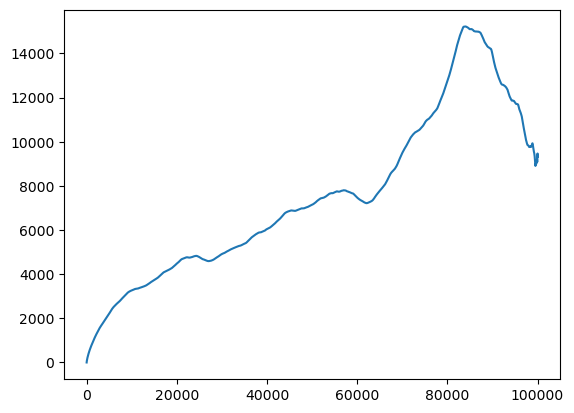

In [34]:
nframes = MSD.n_frames
timestep = 1 # this needs to be the actual time between frames
lagtimes = np.arange(nframes)*timestep # make the lag-time axis
fig = plt.figure()
ax = plt.axes()
# plot the actual MSD
ax.plot(lagtimes, core_msd)#, lc="black", ls="-", label=r'3D random walk')
#exact = lagtimes*6
# plot the exact result
#ax.plot(lagtimes, exact, lc="black", ls="--", label=r'$y=2 D\tau$')

plt.show()

### g_2(t): mean-square-displacement in center of gravity of chain in the center of mass reference

In [37]:
#time = []
rgyr = []
for ts in cell.trajectory:
    #if ts.time == 0:
    #if ts == 
    #time.append(cell.trajectory.time)
    rgyr.append(bug.radius_of_gyration())


In [39]:
np.asarray(rgyr).mean()

21.5172431463686

In [ ]:
def gyr_squared(group, gyr_0, wrap=False):
    """Radius of gyration.
    Parameters
    ----------
    wrap : bool, optional
        If ``True``, move all atoms within the primary unit cell before
        calculation. [``False``]
    .. versionchanged:: 0.8
       Added `pbc` keyword
    .. versionchanged:: 2.1.0
       Renamed `pbc` kwarg to `wrap`. `pbc` is still accepted but
       is deprecated and will be removed in version 3.0.
    """
    atomgroup = group.atoms
    masses = atomgroup.masses
    com = atomgroup.center_of_mass(wrap=wrap)
    if wrap:
        recenteredpos = atomgroup.pack_into_box(inplace=False) - com
    else:
        recenteredpos = atomgroup.positions - com - gyr_0
    rog_sq = np.sum(masses * np.sum(recenteredpos**2,
                                    axis=1)) / atomgroup.total_mass()
    return rog_sq

In [ ]:
#ljcut_coeff = 1.122462
#hns_core_mon_cutoff = 0.5*(sim_info.dmon + sim_info.dhns) #* 5# * ljcut_coeff
hns_pole_mon_cutoff = 0.5*(sim_info.dmon + 0.178) #* ljcut_coeff
#mon_mon_cutoff = 0.5*(sim_info.dmon*ljcut_coeff)
#dist_array_core_contact = np.zeros((sim_info.nmon, sim_info.nhns), dtype=np.int64)
#dist_array_pole_contact = np.zeros((sim_info.nmon, 2*sim_info.nhns), dtype=np.int64)
#dist_array_mon_contact = np.zeros((sim_info.nmon, sim_info.nmon), dtype=np.int64)


In [ ]:
from collections import defaultdict
dist_m_hcore = distances.distance_array(bug, hns_core, box=cell.dimensions)
contact_m_hcore = np.asarray(dist <= hns_core_mon_cutoff, dtype=int)
contact_m_m = np.matmul(contact_m_hcore, contact_m_hcore.T)
contact_m_m = np.transpose(contact_m_m.nonzero())
#contact_m_m_idx = defaultdict(list)
#for pair in contact_m_m:
#    contact_m_m_idx[pair[0]].append(pair[1])
#contact_m_m_idx

In [ ]:
contact_m_m.sum()

In [ ]:
np.trace(contact_m_m)

In [ ]:
%%time
for ts in sliced_trj:
    # bug:
    #dist_m_hcore = distances.distance_array(bug, hns_core, box=cell.dimensions)
    #contact_m_hcore = np.asarray(dist <= hns_core_mon_cutoff, dtype=int)
    #contact_m_m = np.matmul(contact_m_hcore, contact_m_hcore.T)
    dist_m_pcore = distances.distance_array(bug, hns_pole, box=cell.dimensions)
    contact_m_pcore = np.asarray(dist_m_pcore <= hns_pole_mon_cutoff, dtype=int)
    contact_m_m = np.matmul(contact_m_pcore, contact_m_pcore.T)
    contact_m_m_acc += contact_m_m
    #dummy = distances.distance_array(bug, hns_core, box=cell.dimensions)
    #dummy = np.asarray(dummy <= hns_core_mon_cutoff, dtype=int)
    #dist_array_core_contact += dummy
    #dummy = distances.distance_array(bug, hns_pole, box=cell.dimensions)
    #dummy = np.asarray(dummy <= hns_pole_mon_cutoff, dtype=int)
    #dist_array_pole_contact += dummy
    #dummy = distances.distance_array(bug, bug, box=cell.dimensions)
    #dummy = np.asarray(dummy <= mon_mon_cutoff, dtype=int)
    #dist_array_mon_contact += dummy

#dist_array_core_contact_mean = dist_array_core_contact / n_frames
#dist_array_pole_contact_mean = dist_array_pole_contact / n_frames
#dist_array_mon_contact_mean = dist_array_mon_contact / n_frames
#np.save(
#    save_to + sim_name + "distCoreMonMean.npy",
#    dist_array_core_contact_mean
#)
#np.save(
#    save_to + sim_name + "-distPoleMonMean-New.npy",
#    dist_array_pole_contact_mean
#)
contact_m_m_acc = contact_m_m_acc / n_frames
np.save(
    save_to + sim_name + "-ContactMapMonMonMean-New.npy",
    contact_m_m_acc
)
#np.save(
#    save_to + sim_name + "distMonMonMean.npy",
#    dist_array_pole_contact_mean
#)

In [ ]:
sns.heatmap(contact_m_m_acc, cmap='rocket_r',# vmin=0, vmax=0.03
                     )

In [ ]:
glob("./N200*"+phys_attrs[attr]+".npy")[-2]

In [ ]:
np.load(glob("./N200*"+phys_attrs[attr]+".npy")[-2]).shape

## Visualizing contacts:

In [ ]:
phys_attrs = {
    #"Core": "distCoreMonMean-cutoff*",
    #"Pole": "distPoleMonMean-cutoff*"
    "Core-Mon": "ContactMonMon-Core-cutoff*",
    "Pole-Mon": "ContactMonMon-Pole-cutoff*"
    
}
attr = "Core-Mon"
dists = glob("./N200*"+phys_attrs[attr]+".npy")
dists = sorted(dists)
dists = dists
dist_lists = []
for dist in dists:
    dist_info = HnsCub(
        dist,
        'whole',
        'cubic',
        'nucleoid',
        'ring'
    )
    
    dist_lists.append([dist_info.nhns, dist_info.dcrowd, round(dist_info.phi_c_bulk,2), dist_info.nmon, dist_info.filepath])
dist_lists.sort(key=lambda dist: (dist[0], dist[2]))

In [ ]:
rc_params = {
    'mathtext.default': 'regular',
    #'text.usetex': True
}
sns.set_theme(
 #   context='paper',
    font='Times New Roman',
    font_scale=1.5,
    rc=rc_params
)
fig, axes = plt.subplots(nrows=5, ncols=2, sharey=True, figsize=(15,20))
#cbar_ax = fig.add_axes([.91, .2, .03, .6])
nmon = 200
for idx, (dist, ax) in enumerate(zip(dist_lists, axes.flatten(order='F'))):
    pole_data = np.load(dist[-1])
    if attr in ["Core-Mon", "Pole-Mon"]:
        np.fill_diagonal(pole_data, 0)
    ax_hmap = sns.heatmap(
        pole_data, ax=ax, cmap='rocket_r', #vmin=0, vmax=0.02, # Pole
        #pole_data, ax=ax, cmap='rocket_r', vmin=0, vmax=0.045,  # Core
        #square=True
        #cbar_kws={'label': 'Normalized contacts'},
        #cbar= idx > 4,
        #cbar_ax= None if idx==0 else cbar_ax,
    )
    
    #ax.set_xticks(np.arange(0.5,2*dist[0]+0.5,5))
    #ax.set_xticklabels(np.arange(1,2*dist[0],5))
    #ax.set_xticks(np.arange(0.5,dist[0]+0.5,5))
    #ax.set_xticklabels(np.arange(1,dist[0],5))
    ax.set_xticks(np.arange(0.5,dist[3]+0.5,30))
    ax.set_xticklabels(np.arange(1,dist[3],30))
    ax.set_yticks(np.arange(0.5,dist[3],30))
    ax.set_yticklabels(np.arange(1,dist[3],30))
    if idx < 5:
        ax.set_ylabel('Monomer (index)')
    if idx % 5 == 4:
        ax.set_xlabel(f'Hns {attr} (index)')
    ax.set_title(fr'$n_{{hns}}={dist[0]}, \phi_c={dist[2]}, a_c={dist[1]}$')
fig.suptitle(
    r"Normalized number of contacts between monomers and hns " \
        + attr.lower() +  "s in $10^5$ counts"
)
fig.tight_layout(h_pad=1, w_pad=0)#rect=[0, 0, .9, 1])
fig.savefig("ContantMap-"+attr+"Mon-cutoff1.0.pdf")

# Visualizing persistance length

In [ ]:
import scipy
def fit_exponential_decay(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def expfunc(x, a):
        return np.exp(-x/a)
    a = scipy.optimize.curve_fit(expfunc, x, y)[0][0]
    return a

In [ ]:
# LOad data
allInOne_db = '/Users/amirhsi_mini/research_data/analysis/'
group = 'nucleoid'
geometry = 'cubic'
topology = 'ring'
project = 'HnsCub'
bond_corr = '-'.join(['allInOne', project, group, 'chainBondCosCorr.csv'])
bond_corr = allInOne_db + bond_corr
bond_corr = pd.read_csv(bond_corr)
bond_corr.drop(
    columns=['bondCosineCorrVecMon-var','bondCosineCorrVecMon-sem'],
    inplace =True
)

In [ ]:
bond_corr_ens[bond_corr_ens.bin_center>100]

In [ ]:
# a sorted list of unique spaces in the dataset
ensemble_longs = bond_corr['ensemble_long'].unique()
project_titles = {}
bond_corr['exp_fit'] = 0
for ensemble_long in ensemble_longs:
    s_info = HnsCub(
        ensemble_long,
        'ensemble_long',
        geometry,
        group,
        topology,
        ispath=False
    )
    bond_corr_ens = bond_corr[bond_corr['ensemble_long']==ensemble_long]
    bond_corr_ens_idx = bond_corr_ens.index
    per_length = fit_exponential_decay(
        bond_corr_ens['bin_center'], 
        bond_corr_ens['bondCosineCorrVecMon-mean']
    )
    bond_corr.loc[bond_corr_ens_idx,'exp_fit'] = \
        bond_corr_ens.loc[:, 'bin_center'].apply(lambda x: np.exp(-x/per_length))


In [ ]:
y_prop = 'bondCosineCorrVecMon-mean'
col_attr = 'nhns'
col_order = sorted(bond_corr[col_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(bond_corr[hue_attr].unique())
style_attr = 'dcrowd'
style_order = sorted(bond_corr[style_attr].unique())
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'paper'
font_scale = 2
height = 4
aspect = 1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True,        
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
bond_grid = sns.relplot(
    data=bond_corr,
    x='bin_center',
    y=y_prop,
    row=col_attr,
    row_order=col_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    ci=None,
    kind='line',
    markers=False,
    legend='full',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
)
bond_grid.set_xlabels('Bond index lag, j')
#bond_grid.set_ylabels(r'$\langle\cos(\theta_{i,i+j})\rangle$')
bond_grid.set_ylabels(r'$\langle\hat{l}_i.\hat{l}_{i+j}\rangle$')
bond_grid.set_titles(r'$N=200, n_{{hns}}={row_name}$')
legend_labels = [attr_labels[hue_attr]] + list(hue_order)  + \
        [attr_labels[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    bond_grid._legend.texts[idx].set_text(new_label)
#bond_grid.tight_layout(w_pad=1)
sns.move_legend(bond_grid, loc='upper left',  **move_legend_kws)
output = "-".join(["equilPlot", project, col_attr, hue_attr, 'bondCosineCorr'])
bond_grid.fig.tight_layout(pad=1)
bond_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)

In [ ]:
corrs = glob("./N200*-bondCosineCorrsVec.npy")
corrs = sorted(corrs)
corr_lists = []
for corr in corrs:
    corr_info = HnsCub(
        corr,
        'whole',
        'cubic',
        'nucleoid',
        'ring'
    )
    corr_lists.append([corr_info.nhns, corr_info.dcrowd, round(corr_info.phi_c_bulk,2), corr_info.nmon, corr_info.filepath])
corr_lists.sort(key=lambda dist: (dist[0], dist[2]))

In [ ]:
fit_exponential_decay(bond_idx, cosine_corrs_acc/n_bonds/n_frames)

In [ ]:
corr_data = np.load(corr[-1])
bonds_per_lag = np.arange(n_bonds,0, -1)
corr_data = corr_data/bonds_per_lag
bond_idx = np.arange(corr[3])
per_length, b, c = fit_exponential_decay(bond_idx[:n_bonds//2], corr_data[:n_bonds//2])
bond_corr = np.exp(-c*bond_idx**b/per_length)
print(per_length, b, c)

In [ ]:
rc_params = {
    'mathtext.default': 'regular',
    #'text.usetex': True
}
sns.set_theme(
    context='paper',
    font='Times New Roman',
    font_scale=1.5,
    rc=rc_params
)
fig, axes = plt.subplots(nrows=6, ncols=2, sharey=True, figsize=(15,20))
#cbar_ax = fig.add_axes([.91, .2, .03, .6])
nmon = 200
for idx, (corr, ax) in enumerate(zip(corr_lists, axes.flatten(order='F'))):
    corr_data = np.load(corr[-1])
    corr_data = np.append(corr_data,corr_data[0])
    bond_idx = np.arange(1,corr[3]+2,1)
    ax_hmap = ax.scatter(
        bond_idx, corr_data,
        #square=True
        #cbar_kws={'label': 'Normalized contacts'},
        #cbar= idx > 4,
        #cbar_ax= None if idx==0 else cbar_ax,
    )
    
    #ax.set_xticks(np.arange(0.5,2*dist[0]+0.5,5))
    #ax.set_xticklabels(np.arange(1,2*dist[0],5))
    #ax.set_xticks(np.arange(0.5,dist[0]+0.5,5))
    #ax.set_xticklabels(np.arange(1,dist[0],5))
    #ax.set_xticks(np.arange(0.5,dist[3]+0.5,30))
    #ax.set_xticklabels(np.arange(1,dist[3],30))
    #ax.set_yticks(np.arange(0.5,dist[3],30))
    #ax.set_yticklabels(np.arange(1,dist[3],30))
    #if idx < 5:
    #    ax.set_ylabel('Monomer (index)')
    #if idx % 5 == 4:
    #    ax.set_xlabel('Hns pole (index)')
    #ax.set_title(fr'$n_{{hns}}={dist[0]}, \phi_c={dist[2]}, a_c={dist[1]}$')
#fig.suptitle(
#    r"Normalized number of contacts between monomers and hns cores in $10^5$ #counts"
#)
#fig.tight_layout(h_pad=1, w_pad=0)#rect=[0, 0, .9, 1])
fig.savefig("PersistanceLength.pdf")

### Test looping

In [ ]:
dir_contacts = np.array(
    [[0, 1, 0, 0, 0],
     [0, 0, 1, 1, 0],
     [1, 0, 0, 0, 0],
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0],
     [0, 0, 1, 0, 1],
     [1, 0, 0, 1, 0]]
    )
dir_contacts

In [ ]:
np.matmul(dir_contacts, dir_contacts.T)

In [ ]:
dir_contacts_up = np.triu(dir_contacts)  # upper triangle
dir_contacts_diag = np.identity(n_atoms, dtype=int)
# dropping diagnal elements:
dir_contacts_up = dir_contacts_up - dir_contacts_diag
# ensuring all diagonal elements are either 0 or 1:
dir_contacts_up[dir_contacts_up < 0] = 0
dir_contacts_low = dir_contacts_up.T  # lower traingle: symmetry!
dir_contacts = dir_contacts_up + dir_contacts_low + dir_contacts_diag
# Creating the full direct contacts matrix
dir_contacts = contact_matrix(dir_contacts)
if save_to is not None:
    output = save_to[0] + \
        f"random_direct_contact-natoms{n_atoms}" + save_to[1]
    np.save(output, dir_contacts)
return dir_contacts

### slicing over different

In [ ]:

t_choice = [  # upper 1.03*10**8
    [3*10**6, 2.53*10**8, r'$\Delta t/\tau=25\times 10^7$'],
    [0.03*10**8, 1.03*10**8, r'$\Delta t/\tau=10\times 10^7$'],
    [0.53*10**8, 1.03*10**8, r'$\Delta t/\tau=5\times 10^7$'],
    [0.83*10**8, 1.03*10**8, r'$\Delta t/\tau=2\times 10^7$'],
    [0.93*10**8, 1.03*10**8, r'$\Delta t/\tau=1\times 10^7$'],
    [0.98*10**8, 1.03*10**8, r'$\Delta t/\tau=0.5\times 10^7$'],
    [1.02*10**8, 1.03*10**8, r'$\Delta t/\tau=0.1\times 10^7$']
]
t_choice = [  # upper 2.03*10**8
    [3*10**6, 2.53*10**8, r'$\Delta t/\tau=25\times 10^7$'],
    [1.03*10**8, 2.03*10**8, r'$\Delta t/\tau=10\times 10^7$'],
    [1.53*10**8, 2.03*10**8, r'$\Delta t/\tau=5\times 10^7$'],
    [1.83*10**8, 2.03*10**8, r'$\Delta t/\tau=2\times 10^7$'],
    [1.93*10**8, 2.03*10**8, r'$\Delta t/\tau=1\times 10^7$'],
    [1.98*10**8, 2.03*10**8, r'$\Delta t/\tau=0.5\times 10^7$'],
    [2.02*10**8, 2.03*10**8, r'$\Delta t/\tau=0.1\times 10^7$']
]
t_choice = [  # upper 1.53*10**8
    [3*10**6, 2.53*10**8, r'$\Delta t/\tau=25\times 10^7$'],
    [0.53*10**8, 1.53*10**8, r'$\Delta t/\tau=10\times 10^7$'],
    [1.03*10**8, 1.53*10**8, r'$\Delta t/\tau=5\times 10^7$'],
    [1.33*10**8, 1.53*10**8, r'$\Delta t/\tau=2\times 10^7$'],
    [1.43*10**8, 1.53*10**8, r'$\Delta t/\tau=1\times 10^7$'],
    [1.48*10**8, 1.53*10**8, r'$\Delta t/\tau=0.5\times 10^7$'],
    [1.52*10**8, 1.53*10**8, r'$\Delta t/\tau=0.1\times 10^7$']
]

In [ ]:
t_choice = [  # upper 1.53*10**8
    [0, 10*10**5, r'$\Delta t/\tau=25\times 10^7$'],
    [5*10**5, 10*10**5, r'$\Delta t/\tau=10\times 10^7$'],
    [1*10**5, 5*10**5, r'$\Delta t/\tau=5\times 10^7$'],
    [5*10**4, 10*10**4, r'$\Delta t/\tau=2\times 10^7$'],
    [2.5*10**4, 5*10**4, r'$\Delta t/\tau=1\times 10^7$'],
    [1.25*10**4, 2.5*10**4, r'$\Delta t/\tau=0.5\times 10^7$'],
    [0, 10**5, r'$\Delta t/\tau=0.1\times 10^7$']
]

In [ ]:
fig, axes = plt.subplots(7,1, figsize=(16,36))
fig.suptitle(r"$t_{final}/\tau=15.3\times 10^7$",y=0.98)
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'both',
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
}
font_family = 'sans-serif'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
for ax, (t_i, t_f, dt) in zip(axes,t_choice):
    gyr_sliced = gyr.loc[(gyr['t']>=t_i)&(gyr['t']<=t_f),:]
    gyr_mean = np.round(gyr_sliced['gyr'].mean(),2)
    ax = sns.lineplot(
        data=gyr_sliced,
        x='t',
        y='gyr',
        ci=None,
        palette=color_palette,
        ax=ax,
        label=dt,
    )
    ax.axhline(
        gyr_mean, color='royalblue',
        label=rf'$\langle \sqrt{{R^2_g}}\rangle={gyr_mean}$', 
        lw=2, ls='-'
    )
    ax.legend(facecolor='white', loc='upper left', ncol=2)
    ax.set_ylabel(r'$\sqrt{R^2_g}/\sigma$')
    ax.set_xlabel(r'$t/\tau$')
fig.tight_layout(w_pad=1, h_pad=0)
plt.show()
fig.savefig("gyrTDna-slices.pdf")

### Semi-log to show reaching equilibrium

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16,18))
color_palette = 'flare'
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'both',
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
}
font_family = 'sans-serif'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
axes[0] = sns.lineplot(
    data=gyr,
    x='t',
    y='gyr',
    ci=None,
    palette=color_palette,
    ax=axes[0]
)
fig.suptitle(r"$\Delta t_{sim}/\tau=28.7\times 10^7$",y=0.92)
axes[0].set_xlabel(r'$t/\tau$')
axes[0].axhline(gyr_mean, color='royalblue', label=r'$\langle \sqrt{R^2_g}\rangle$', 
                lw=2, ls='-')
axes[0].legend(facecolor='white', loc='upper right')
axes[0].set_ylabel(r'$\sqrt{R^2_g}/\sigma$')
axes[1].semilogx(
    gyr['t'],
    gyr['gyr']
)
axes[1].set_xlabel(r'$\log(t/\tau)$')
axes[1].axhline(gyr_mean, color='royalblue', label=r'$\langle \sqrt{R^2_g}\rangle$', 
                lw=2, ls='-')
axes[1].legend(facecolor='white', loc='upper right')
axes[1].set_ylabel(r'$\sqrt{R^2_g}/\sigma$')
plt.show()
fig.savefig("gyrTDna-semiLogX.pdf")